In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'ICL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,1613,-1049,563,132,248,1263,1334,3232,0,...,8344,660,0,881,2293,1824,5163,167,-239,1270.46
1,2014-06-30,1536,-993,542,68,178,1274,1351,3187,0,...,8436,639,0,859,2200,2057,5307,120,-208,1270.46
2,2014-09-30,1560,-982,578,181,177,1168,1277,3327,0,...,8422,563,0,815,2161,2088,5331,283,-207,1270.46
3,2014-12-31,1403,-890,513,85,131,1039,1335,3140,0,...,8348,585,0,603,2003,2304,5374,318,-181,1270.46
4,2015-03-31,1403,-957,446,217,165,1110,1236,2960,0,...,8140,560,0,798,2196,1955,5253,65,-150,1272.26


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,1289.95,2091,-1158,933,342,417,1583,2134,...,852,11750,1006,0,512,2606,2312,6286,467,-212
36,2023-03-31,2023-04-21,1290.67,2098,-1270,828,294,552,1631,2116,...,867,12045,967,0,704,2735,2278,6414,382,-164
37,2023-06-30,2023-07-21,1290.67,1834,-1189,645,167,372,1380,2006,...,872,11584,893,0,674,2431,2117,5914,391,-170
38,2023-09-30,2023-10-21,1290.67,1862,-1276,586,142,307,1387,1722,...,851,11274,814,0,592,2286,1984,5610,407,-191
39,2023-12-31,2024-02-11,1290.67,1690,-1130,560,84,420,1376,1703,...,873,11627,912,0,858,2638,1829,5590,415,-255


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,1289.95,2091,-1158,933,342,417,1583,2134,...,11750,1006,0,512,2606,2312,6286,467,-212,1
36,2023-03-31,2023-04-21,1290.67,2098,-1270,828,294,552,1631,2116,...,12045,967,0,704,2735,2278,6414,382,-164,1
37,2023-06-30,2023-07-21,1290.67,1834,-1189,645,167,372,1380,2006,...,11584,893,0,674,2431,2117,5914,391,-170,1
38,2023-09-30,2023-10-21,1290.67,1862,-1276,586,142,307,1387,1722,...,11274,814,0,592,2286,1984,5610,407,-191,1
39,2023-12-31,2024-02-11,1290.67,1690,-1130,560,84,420,1376,1703,...,11627,912,0,858,2638,1829,5590,415,-255,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,1289.95,2091.0,-1158.0,933.0,342.0,417.0,1583.0,2134.0,...,11750.0,1006.0,0.0,512.0,2606.0,2312.0,6286.0,467.0,-212.0,1
36,2023-03-31,2023-04-21,1290.67,2098.0,-1270.0,828.0,294.0,552.0,1631.0,2116.0,...,12045.0,967.0,0.0,704.0,2735.0,2278.0,6414.0,382.0,-164.0,1
37,2023-06-30,2023-07-21,1290.67,1834.0,-1189.0,645.0,167.0,372.0,1380.0,2006.0,...,11584.0,893.0,0.0,674.0,2431.0,2117.0,5914.0,391.0,-170.0,1
38,2023-09-30,2023-10-21,1290.67,1862.0,-1276.0,586.0,142.0,307.0,1387.0,1722.0,...,11274.0,814.0,0.0,592.0,2286.0,1984.0,5610.0,407.0,-191.0,1
39,2023-12-31,2024-02-11,1290.67,1690.0,-1130.0,560.0,84.0,420.0,1376.0,1703.0,...,11627.0,912.0,0.0,858.0,2638.0,1829.0,5590.0,415.0,-255.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,5.894957,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,0.381232,0.618768,5.108472,6.357576,26.016129,3.145427,0.349039,0.081835,0.063279,0.165986
1,2014-04-28,5.976172,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,0.381232,0.618768,5.108472,6.357576,26.016129,3.145427,0.349039,0.081835,0.063279,0.165986
2,2014-05-05,5.989709,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,0.381232,0.618768,5.108472,6.357576,26.016129,3.145427,0.349039,0.081835,0.063279,0.165986
3,2014-05-12,6.104764,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,0.381232,0.618768,5.108472,6.357576,26.016129,3.145427,0.349039,0.081835,0.063279,0.165986
4,2014-05-19,6.118301,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,0.381232,0.618768,5.108472,6.357576,26.016129,3.145427,0.349039,0.081835,0.063279,0.165986


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,5.894957,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,3.145427,0.349039,0.081835,0.063279,0.165986,14.184293,2.354387,1.160773,1.922552,4.611642
1,2014-04-28,5.976172,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,3.145427,0.349039,0.081835,0.063279,0.165986,14.379711,2.386824,1.176765,1.938544,4.675177
2,2014-05-05,5.989709,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,3.145427,0.349039,0.081835,0.063279,0.165986,14.412284,2.392231,1.179431,1.941210,4.685767
3,2014-05-12,6.104764,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,3.145427,0.349039,0.081835,0.063279,0.165986,14.689126,2.438182,1.202086,1.963865,4.775775
4,2014-05-19,6.118301,2014-03-31,1613.0,0.415598,2.503818,1270.46,1624.0,1.278277,248.0,...,3.145427,0.349039,0.081835,0.063279,0.165986,14.721698,2.443589,1.204751,1.966531,4.786365


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

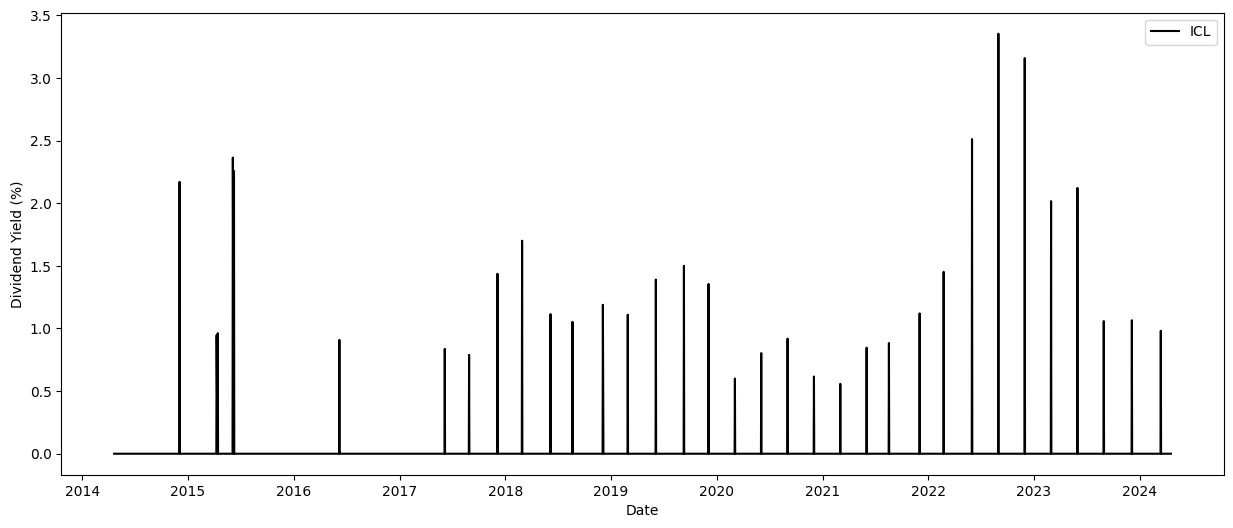

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


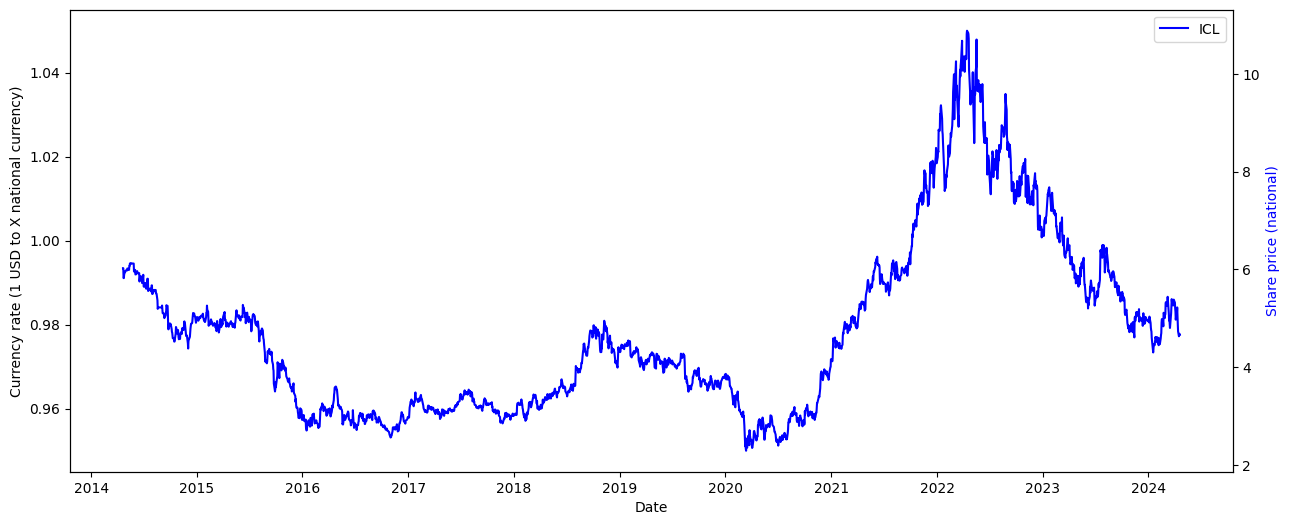

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

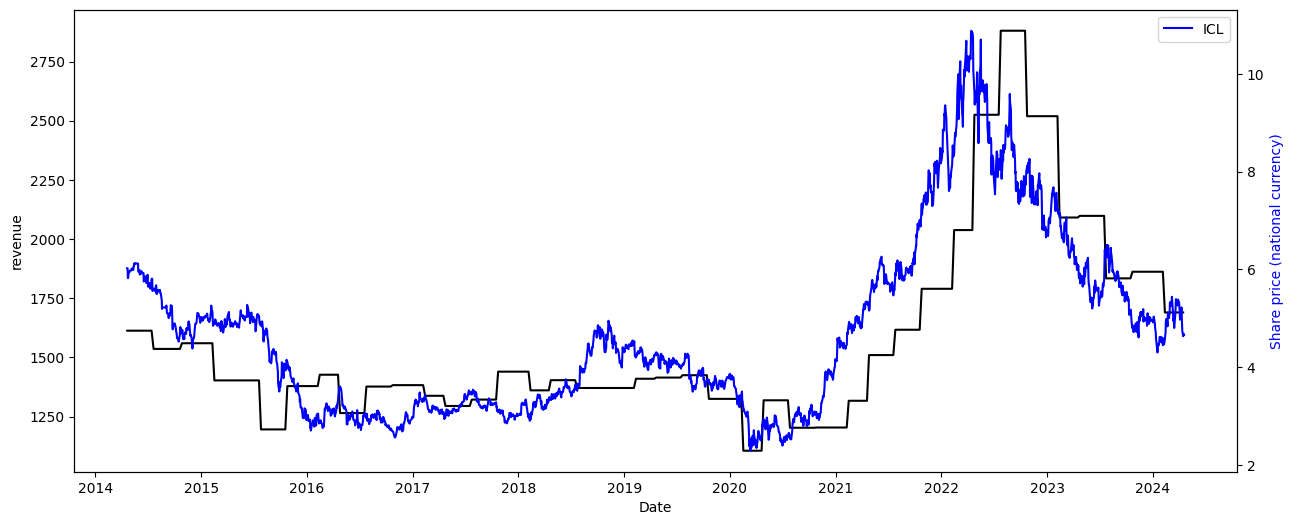

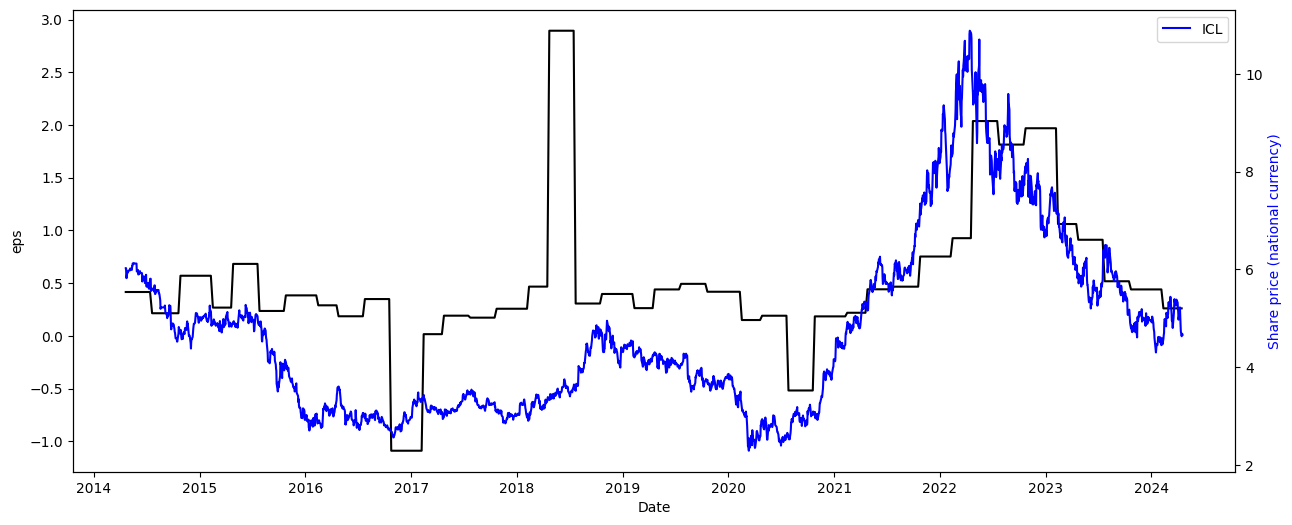

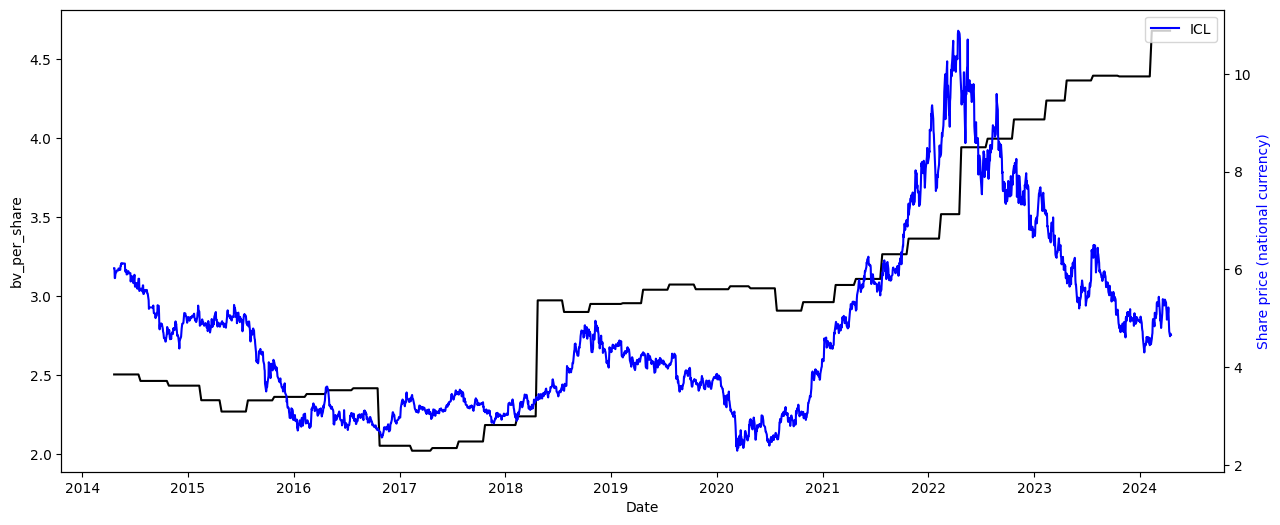

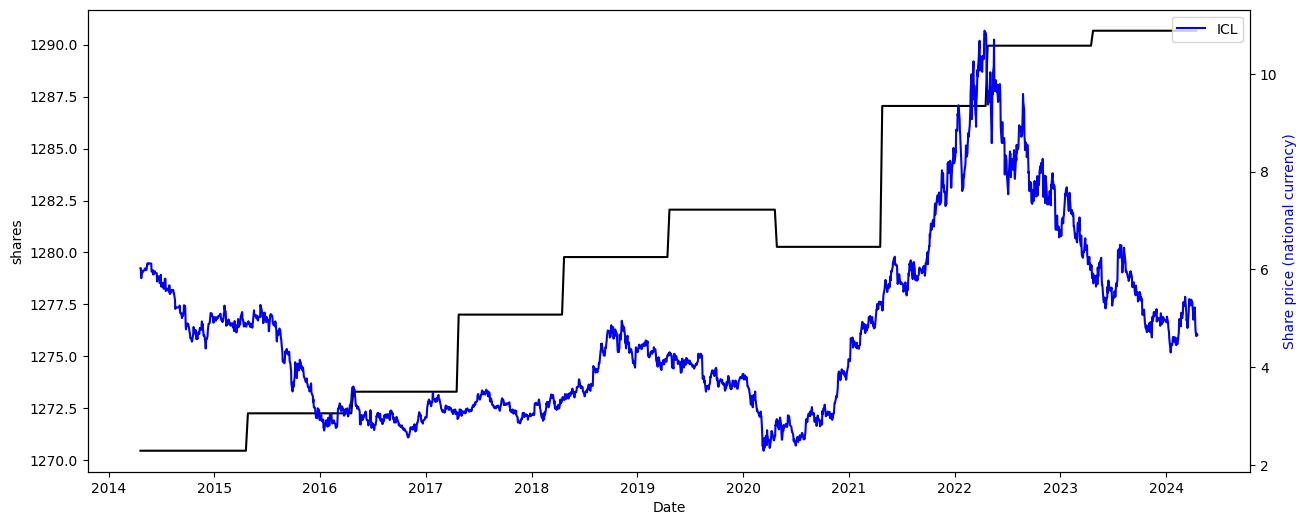

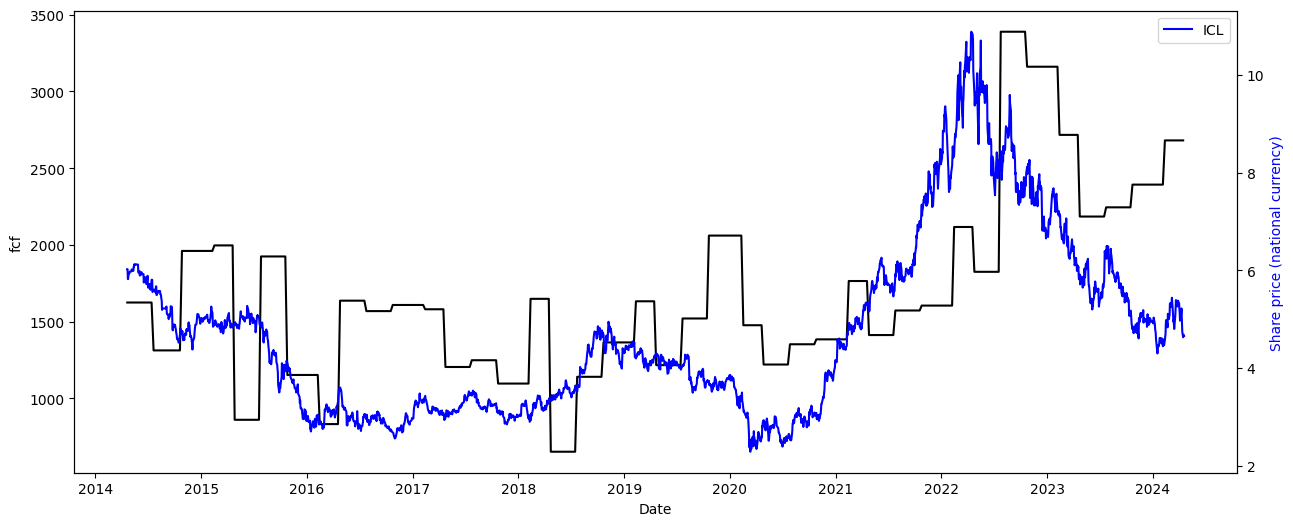

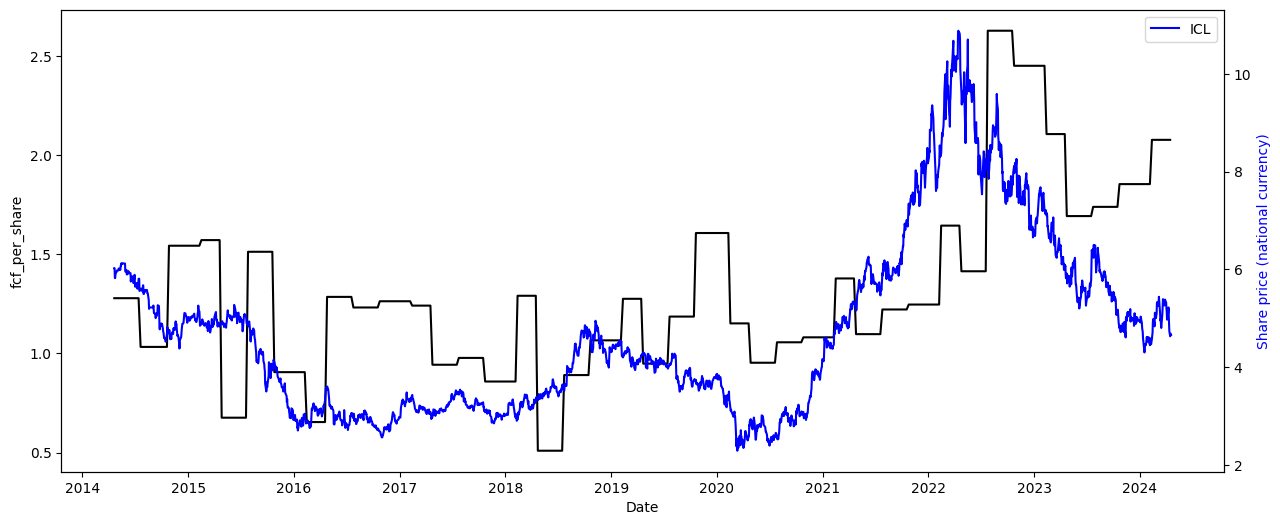

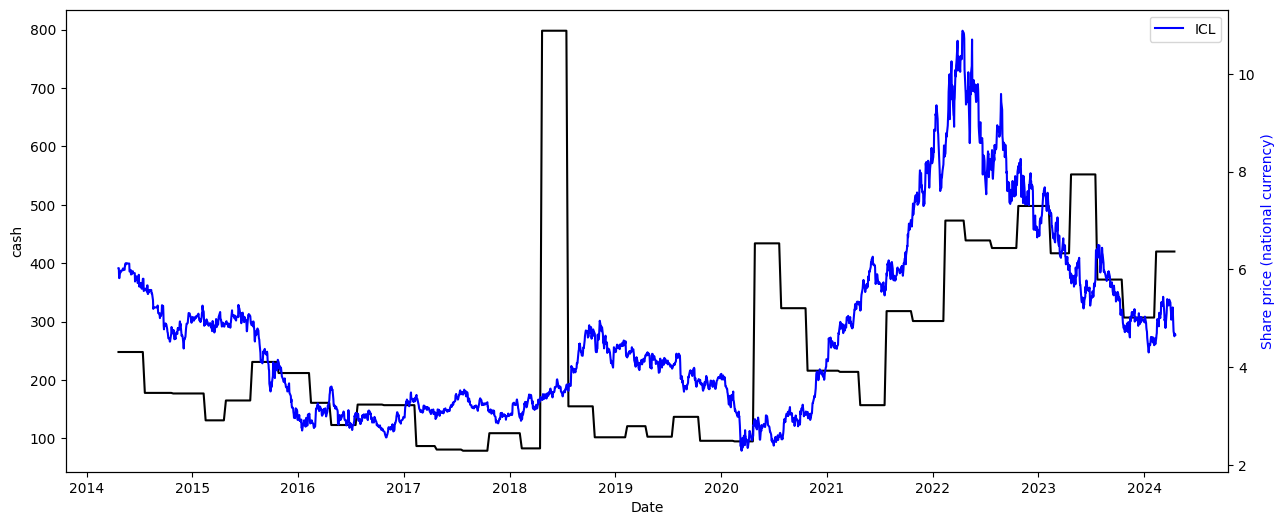

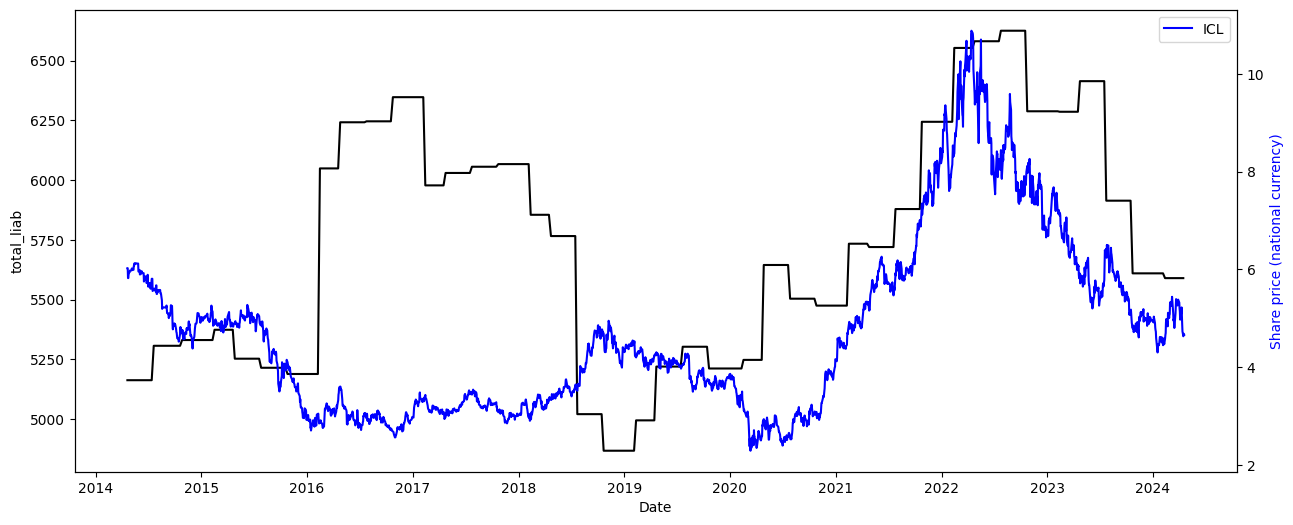

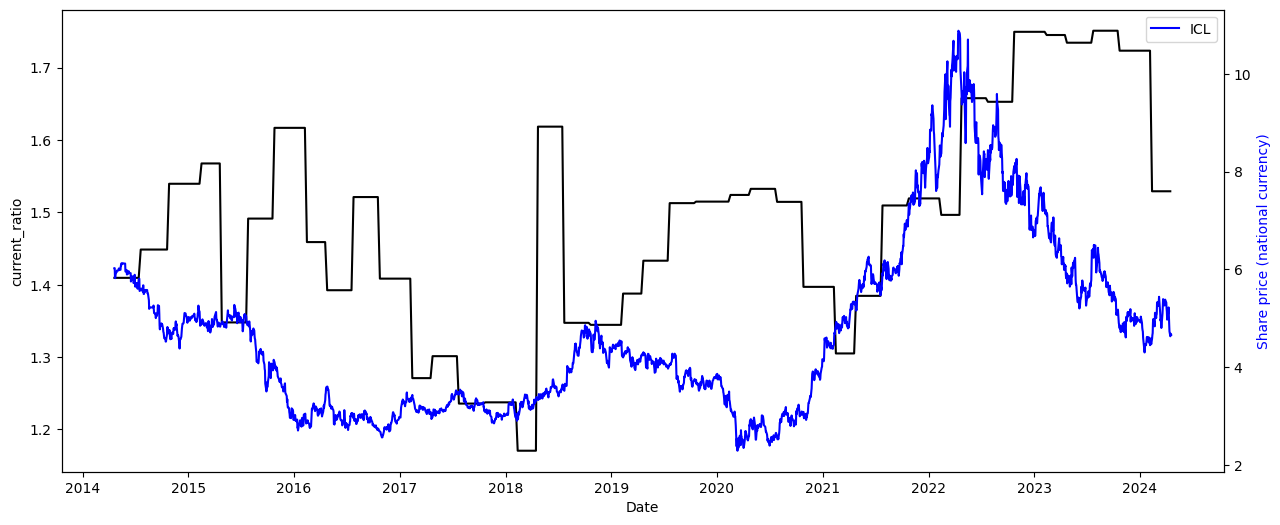

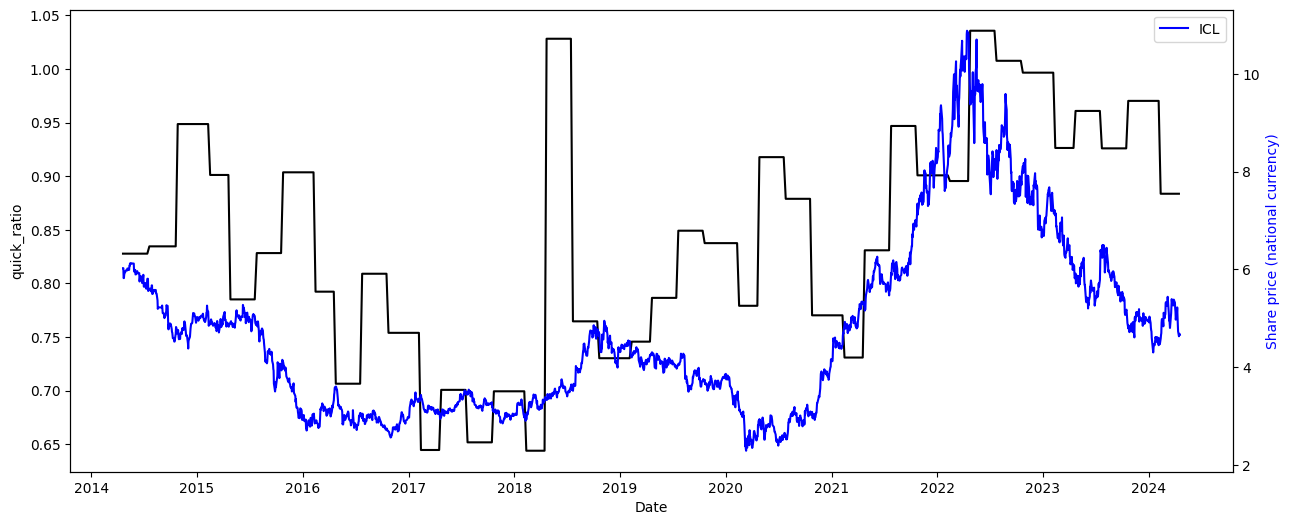

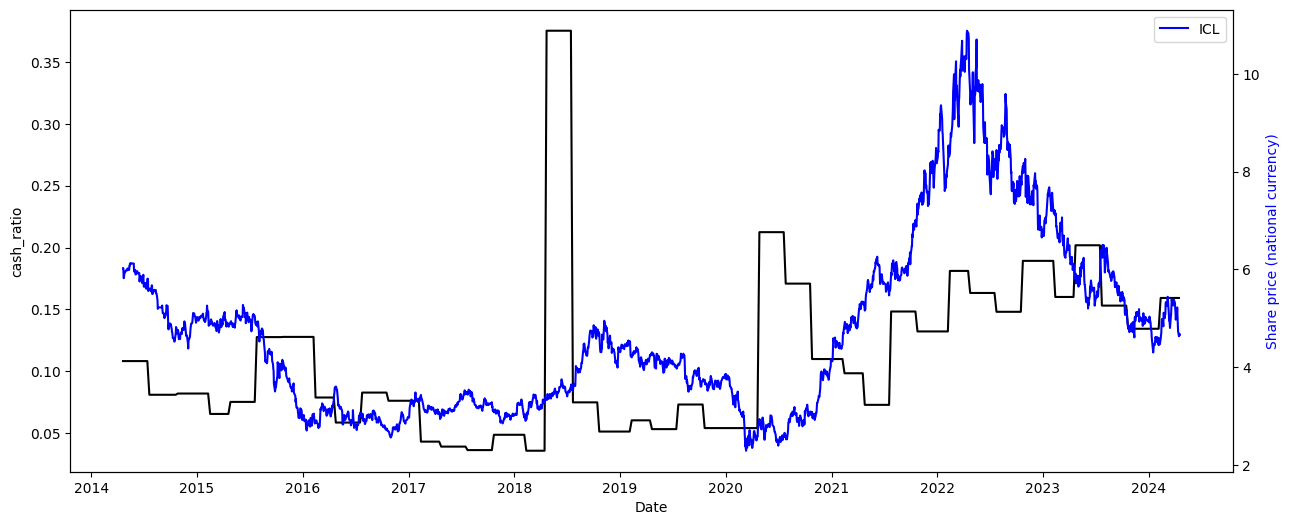

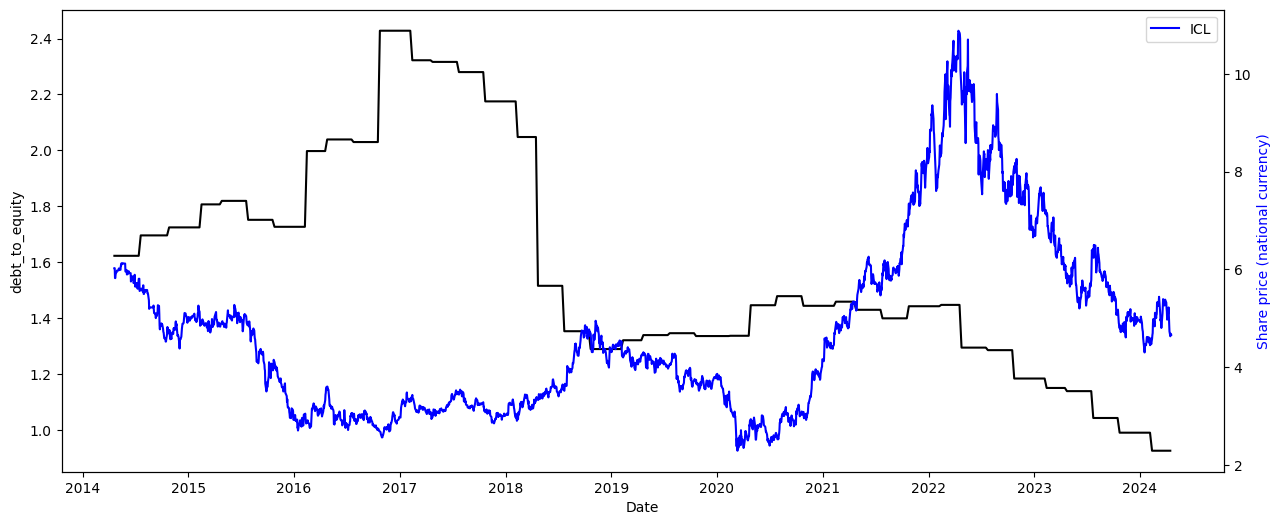

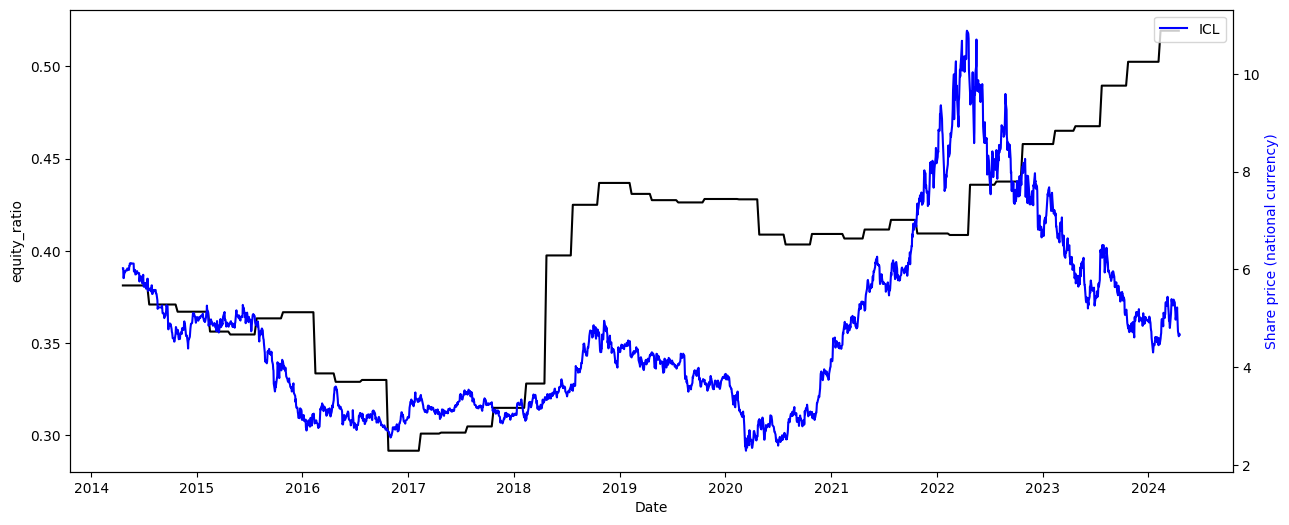

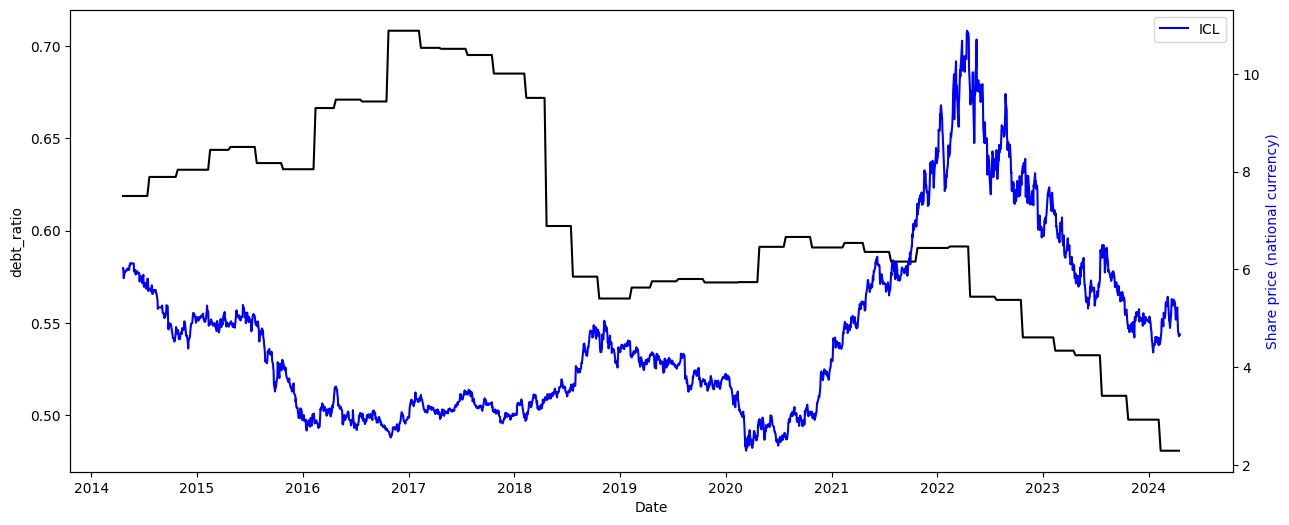

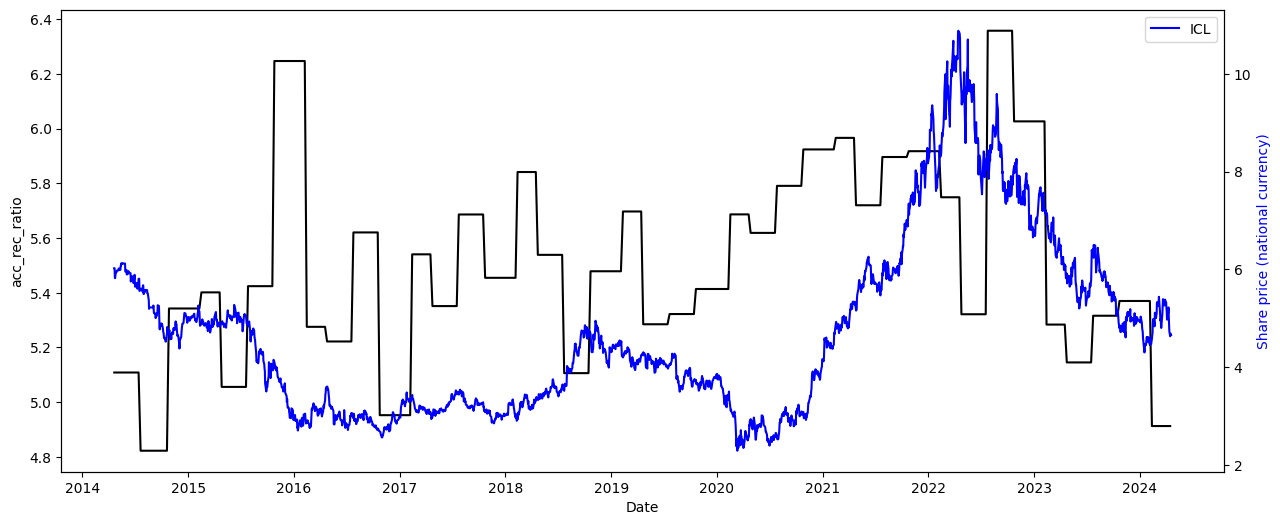

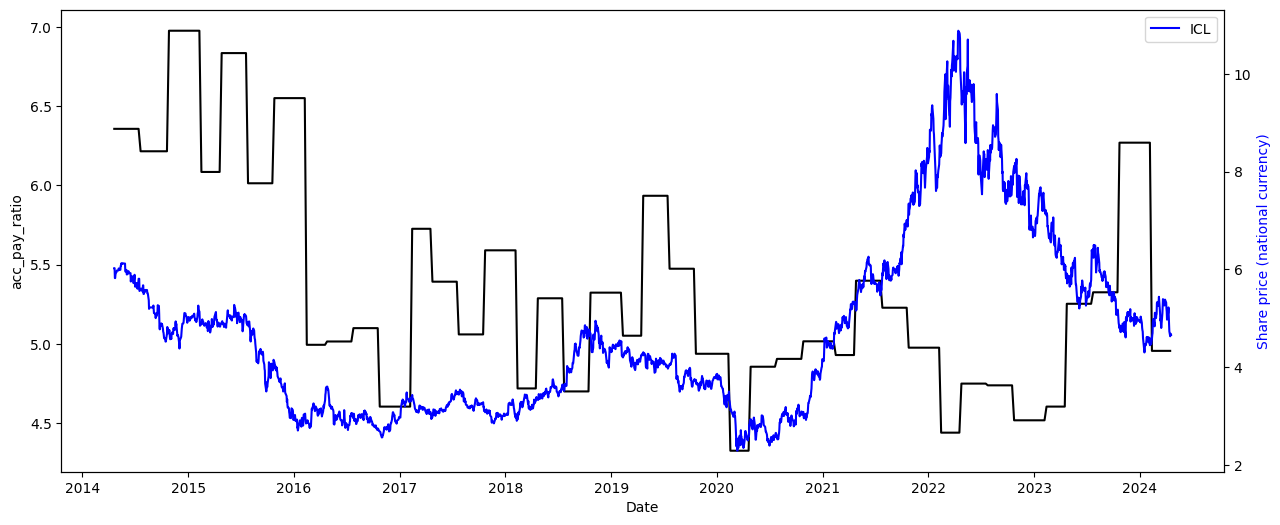

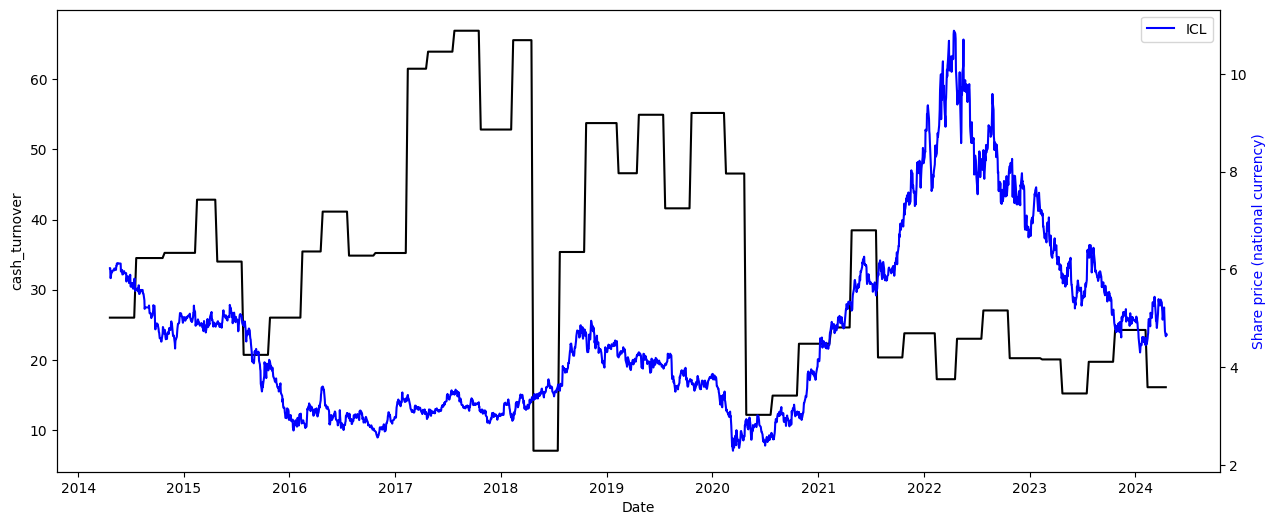

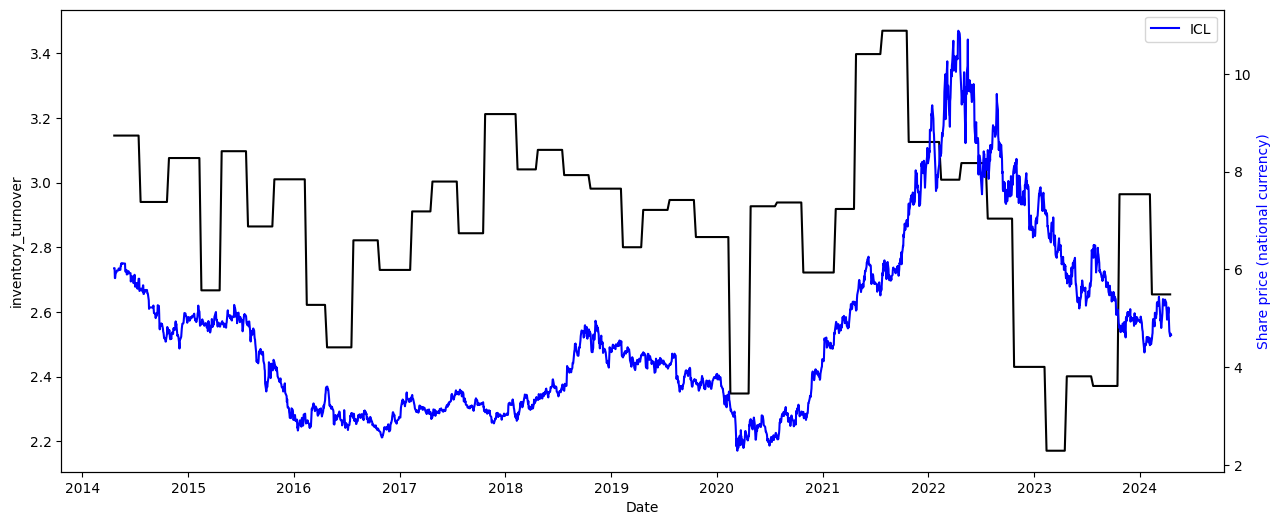

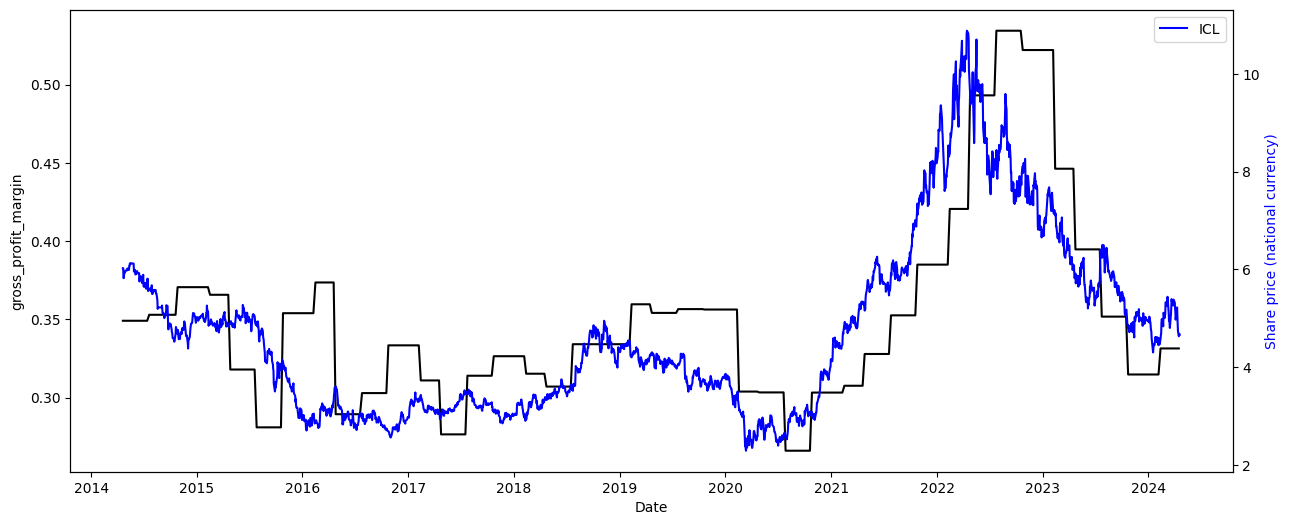

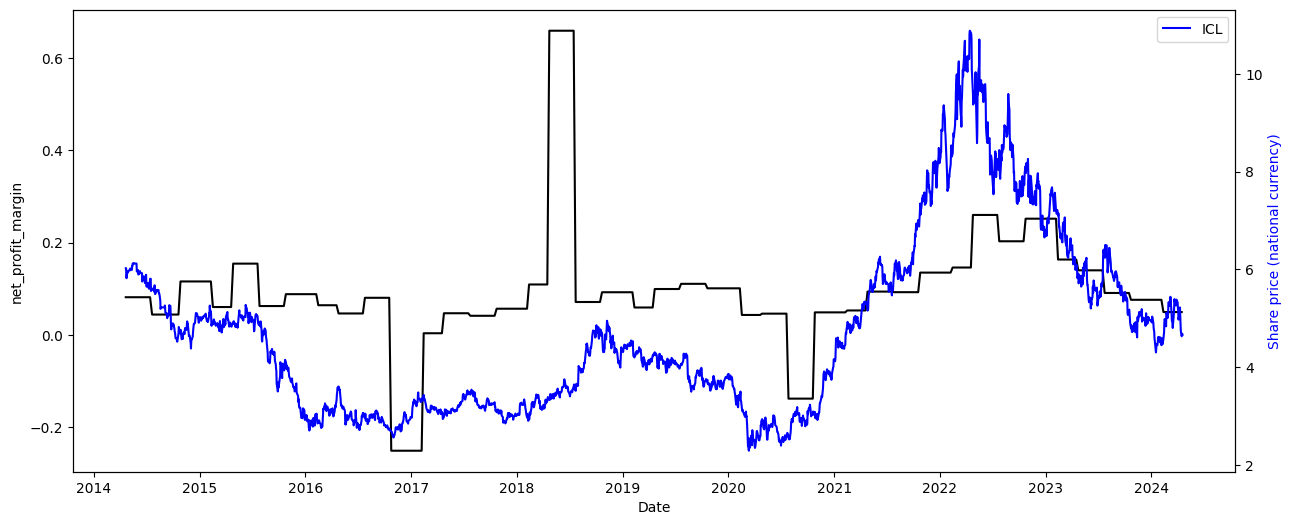

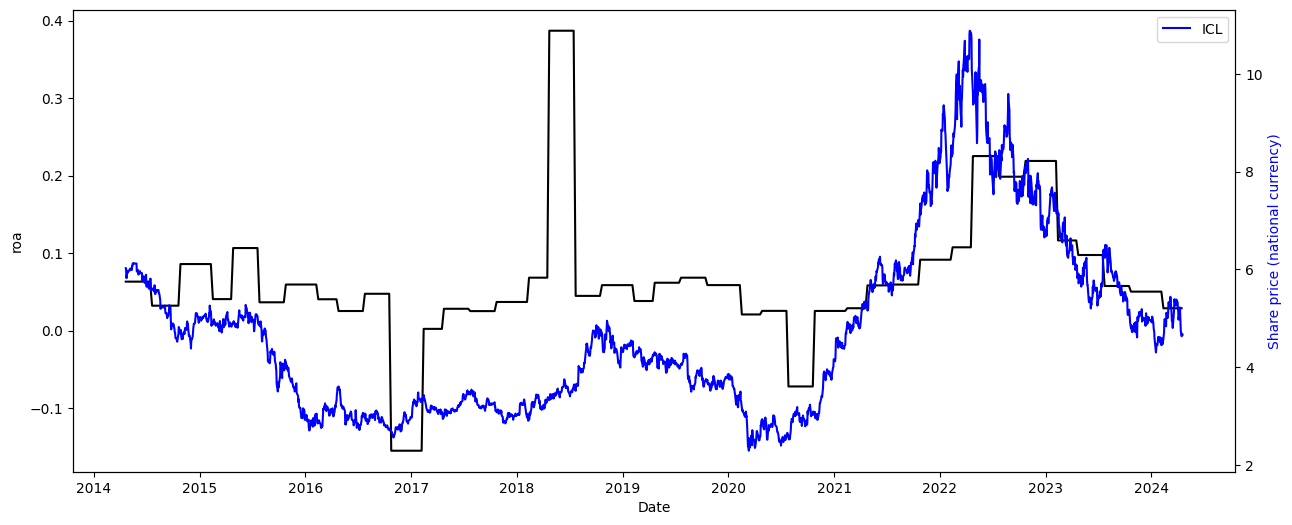

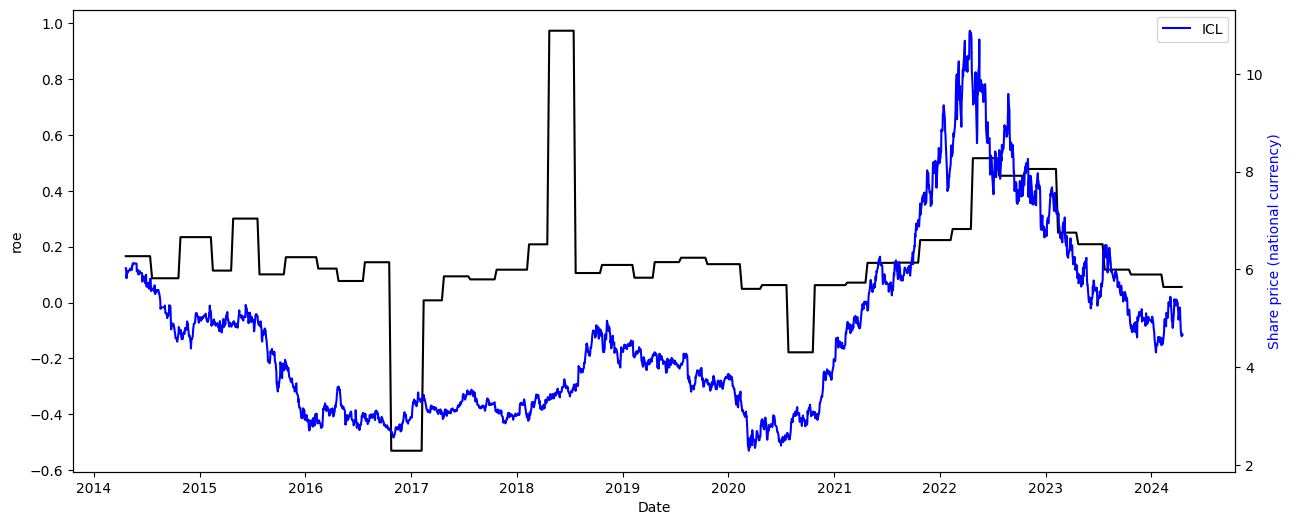

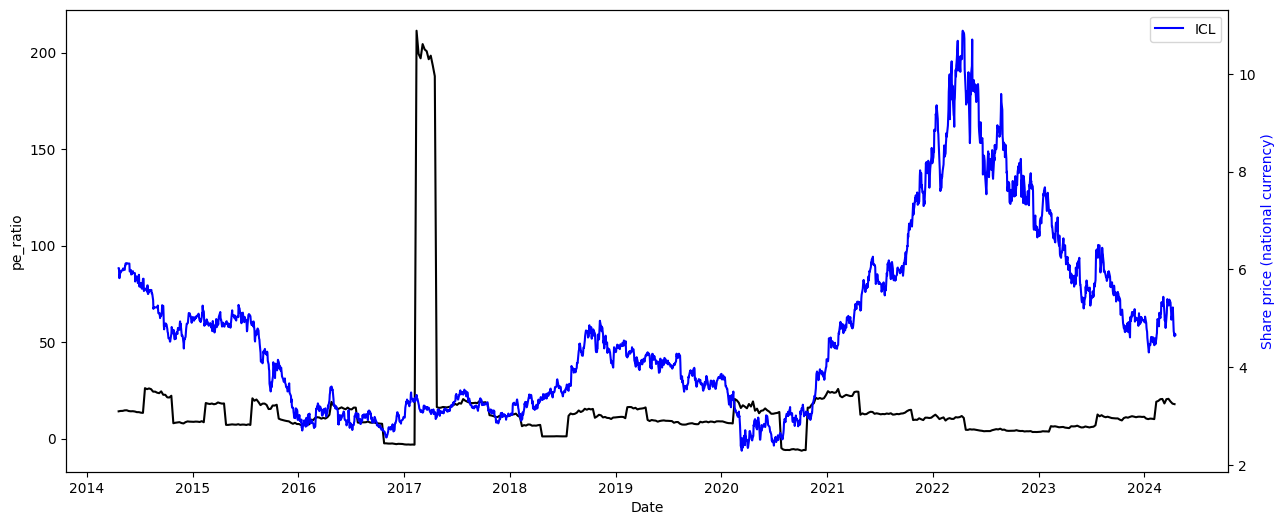

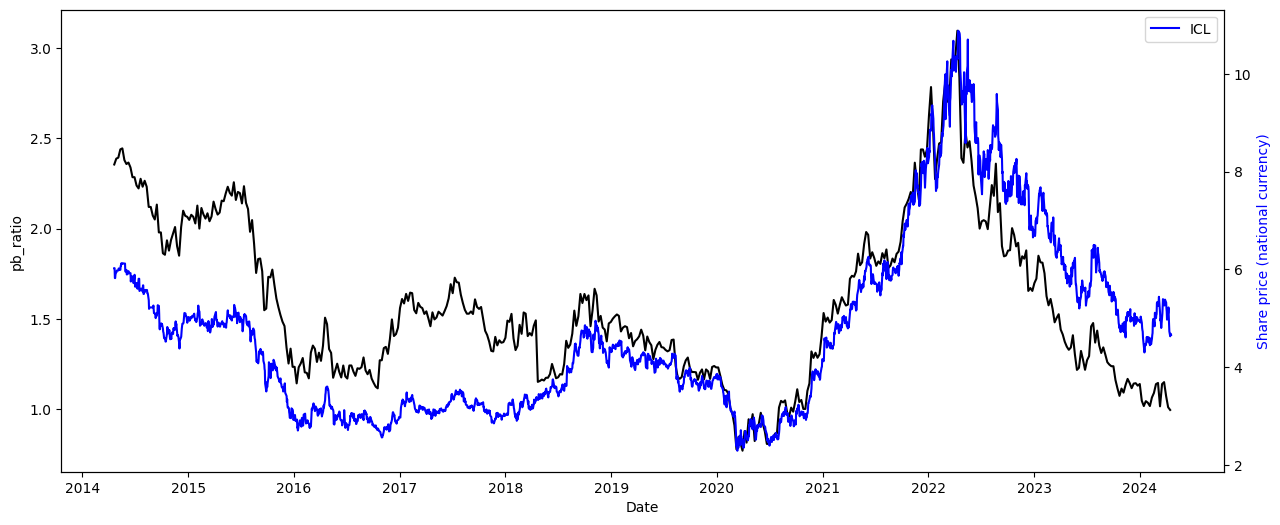

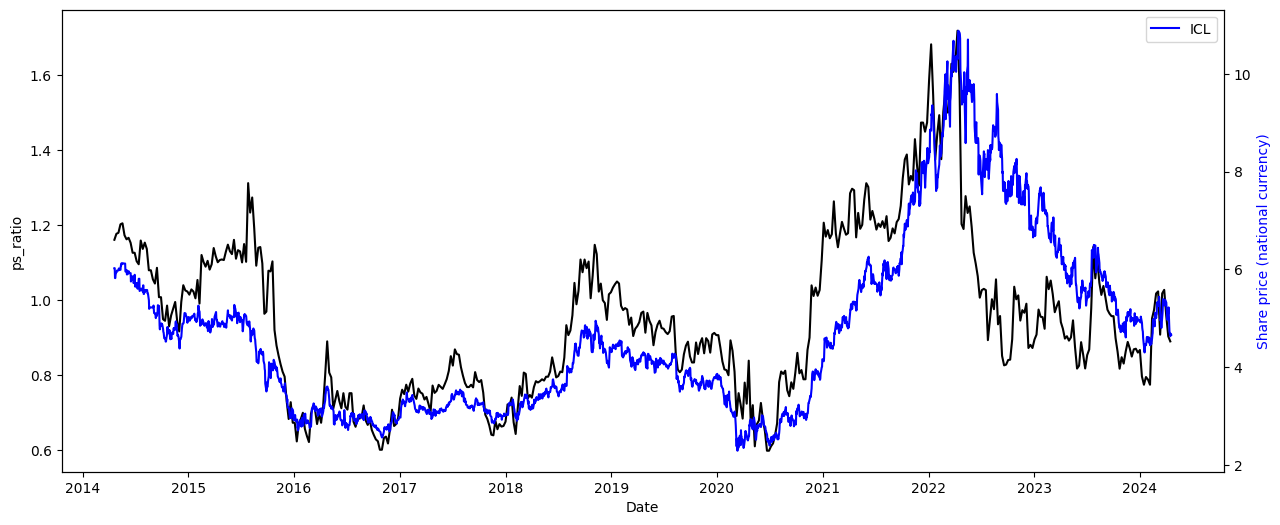

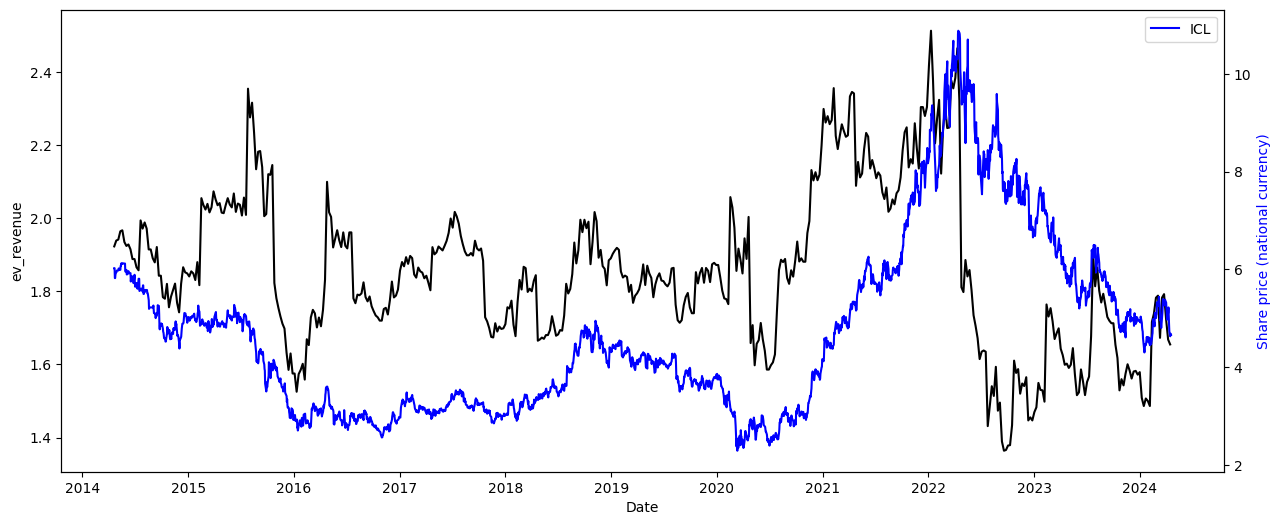

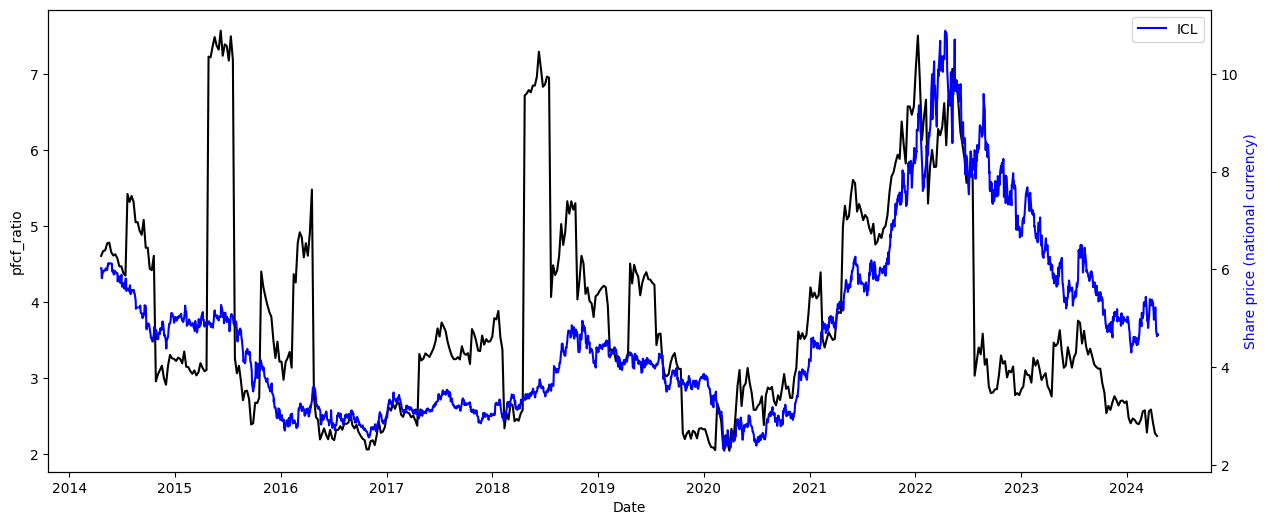

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

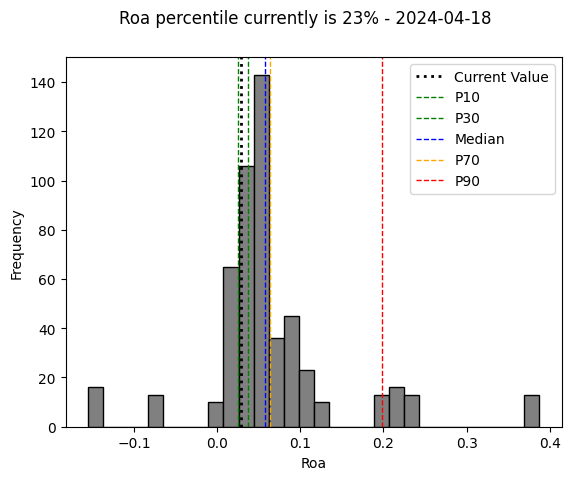

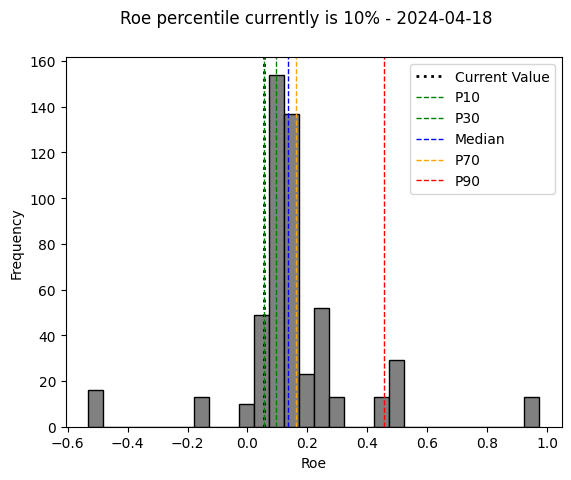

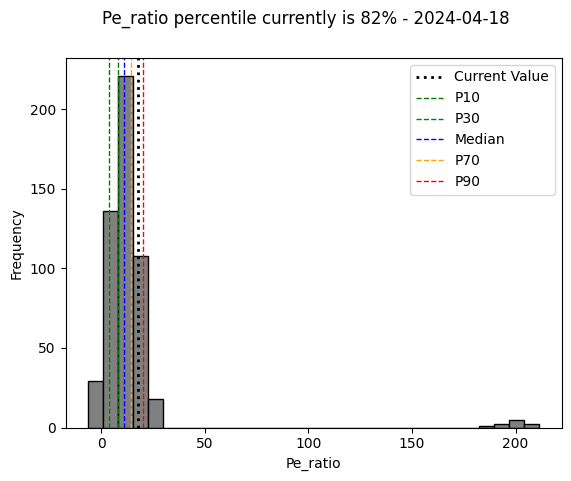

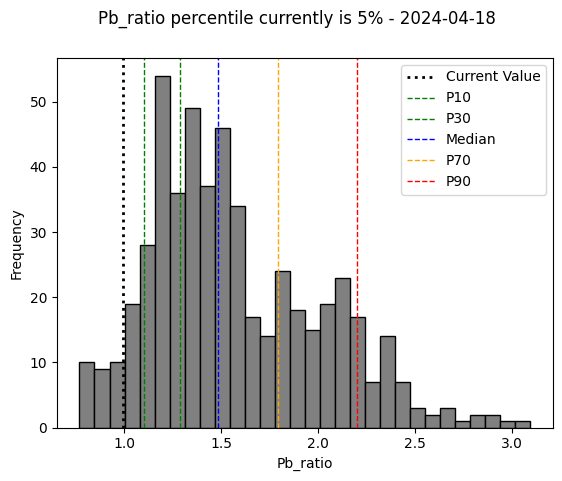

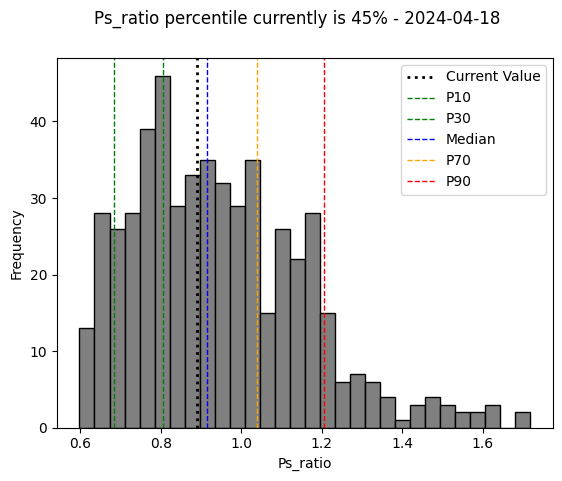

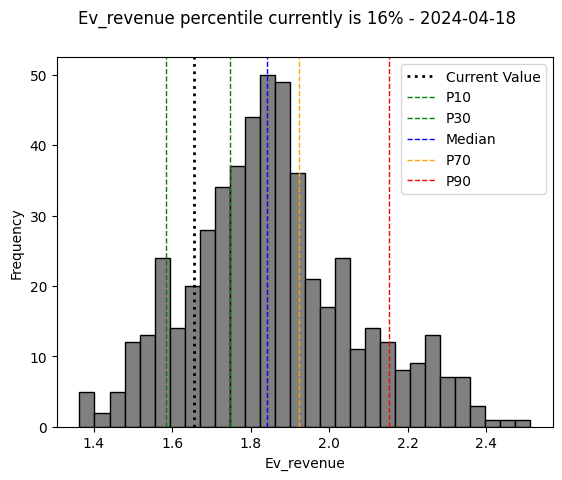

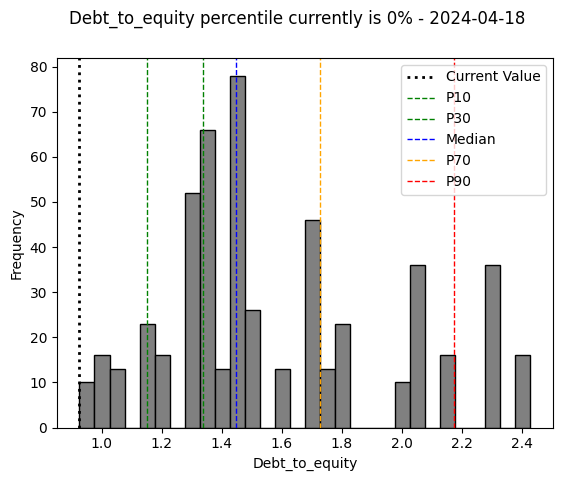

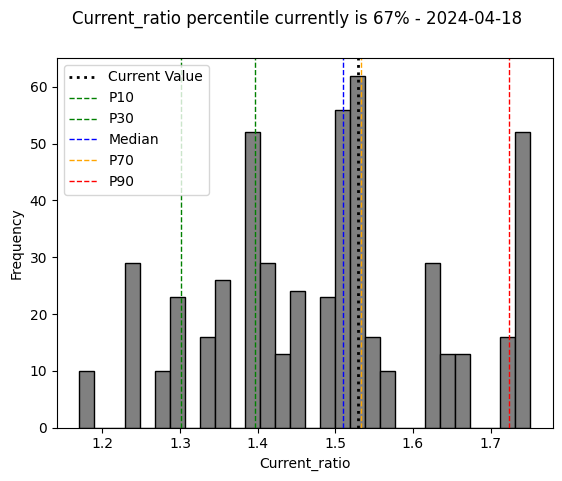

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.988206,-0.147827,0.251591,0.210870,-0.258942,-0.389783,0.436058
roe,0.988206,1.000000,-0.120864,0.246927,0.209225,-0.207496,-0.348225,0.362509
pe_ratio,-0.147827,-0.120864,1.000000,0.015614,-0.060282,0.107304,0.265780,-0.283448
pb_ratio,0.251591,0.246927,0.015614,1.000000,0.784193,0.471415,0.065581,-0.040952
ps_ratio,0.210870,0.209225,-0.060282,0.784193,1.000000,0.692015,-0.370119,0.069386
ev_revenue,-0.258942,-0.207496,0.107304,0.471415,0.692015,1.000000,0.174869,-0.463961
debt_to_equity,-0.389783,-0.348225,0.265780,0.065581,-0.370119,0.174869,1.000000,-0.645147
current_ratio,0.436058,0.362509,-0.283448,-0.040952,0.069386,-0.463961,-0.645147,1.000000


10 timestemos have been found!


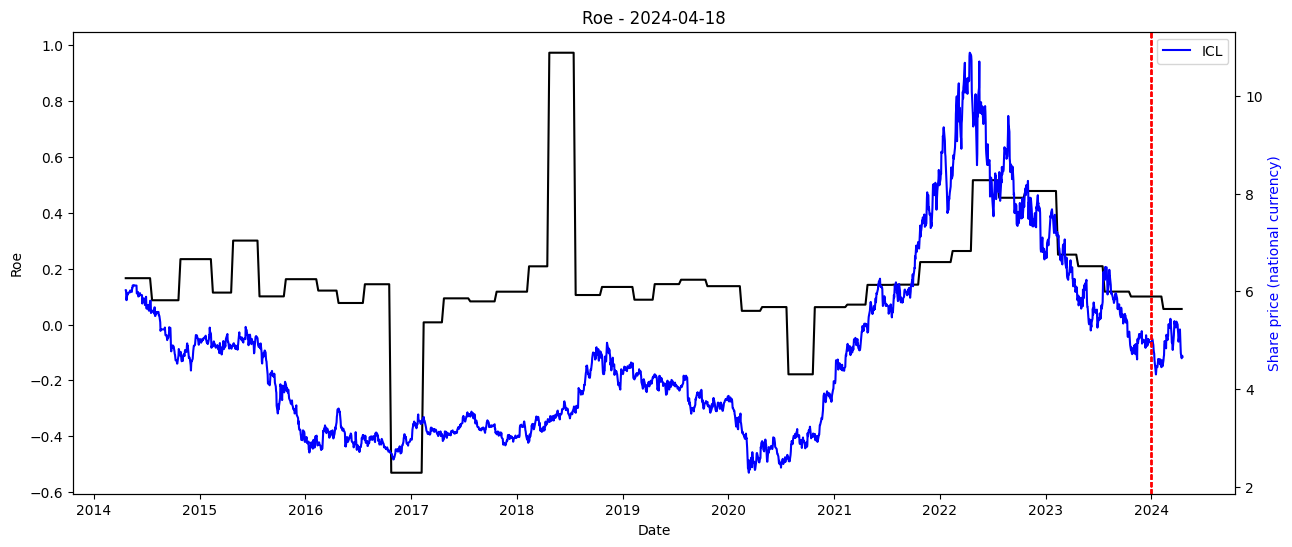

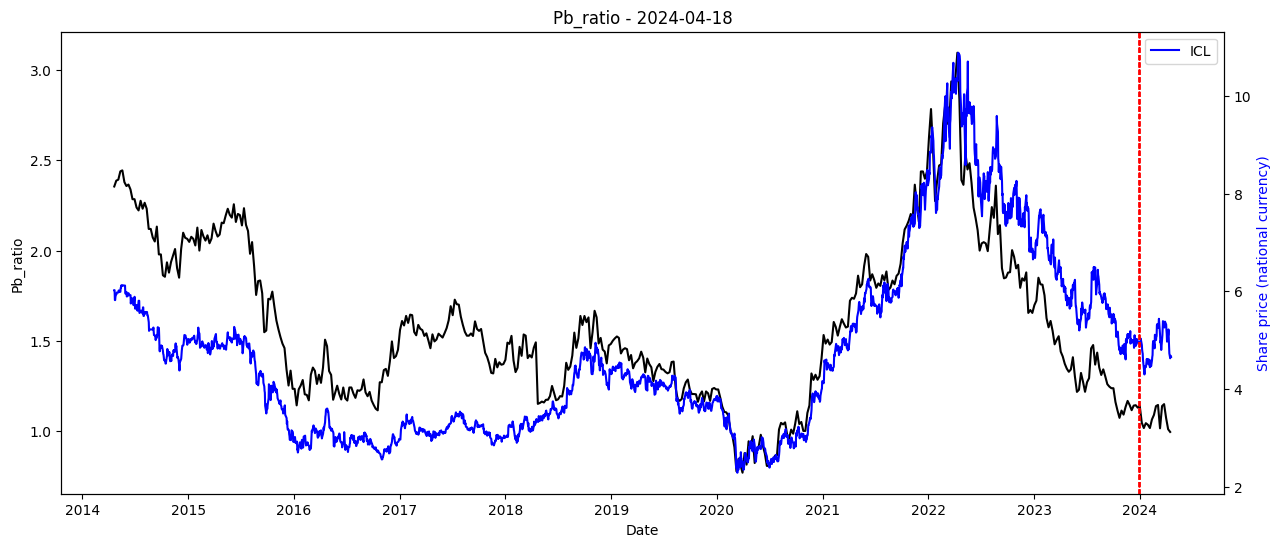

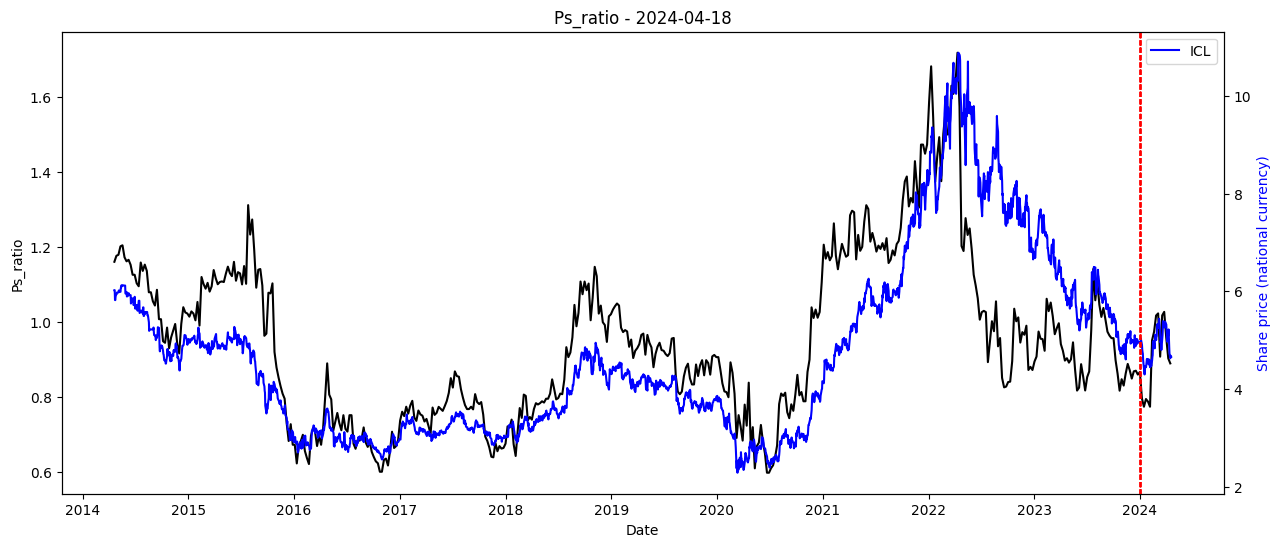

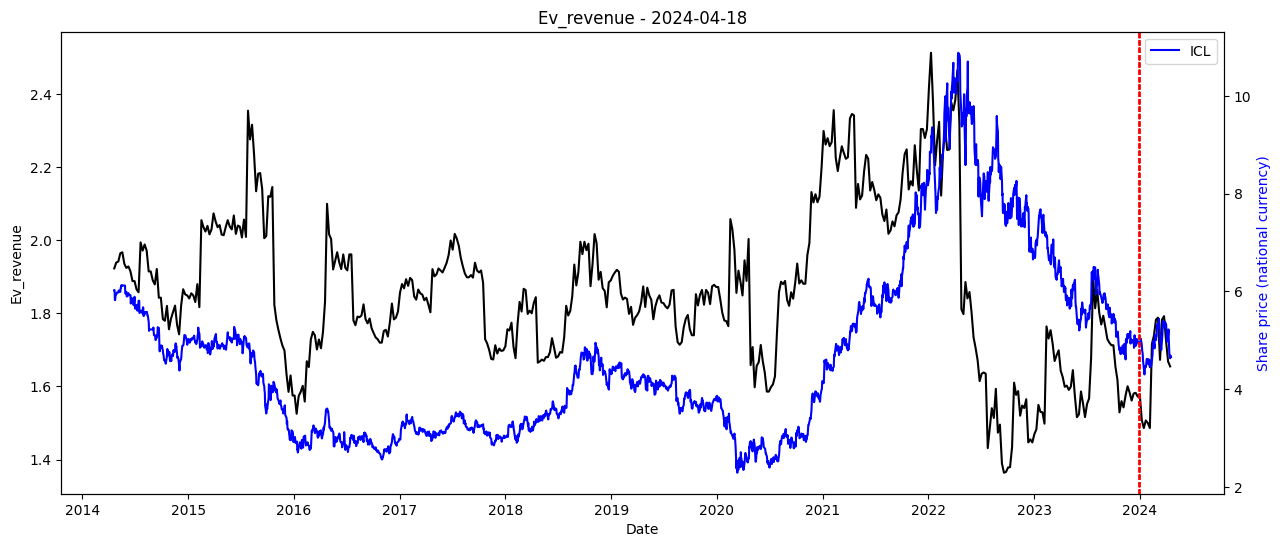

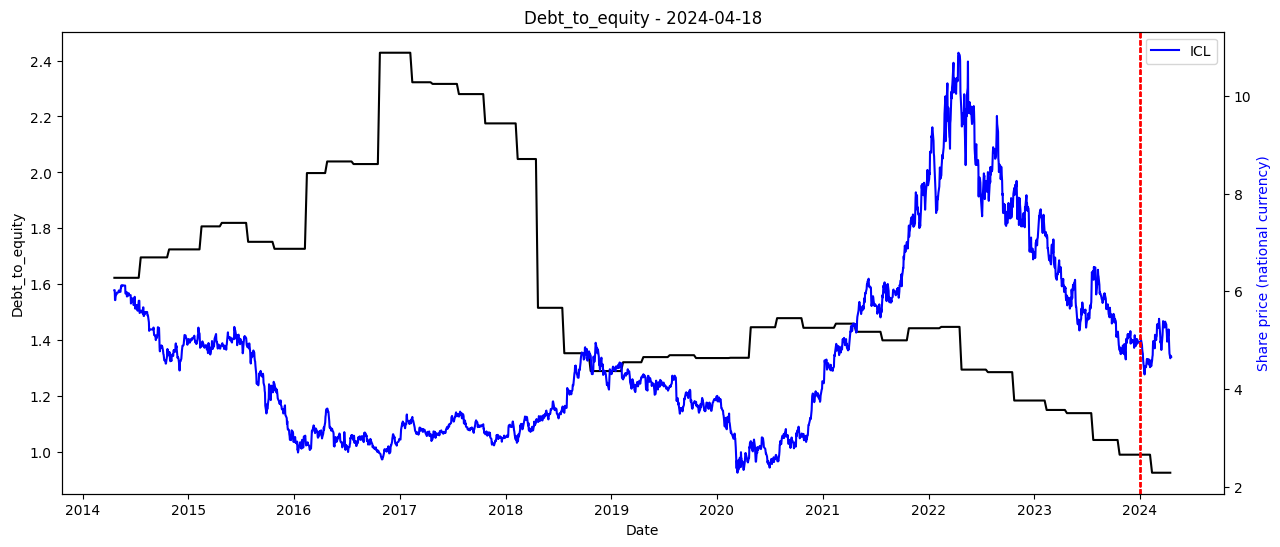

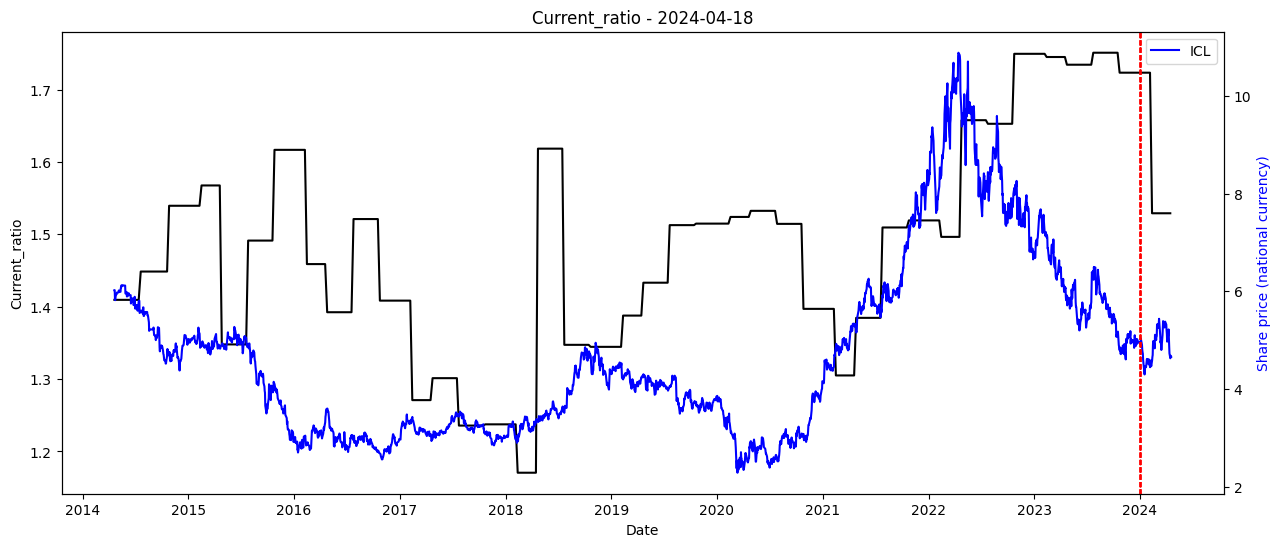

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )